# Predição de Vitórias em Partidas de League of Legends

Esse notebook usa um conjunto de dados disponibilizado pela plataforma Kaggle que contém 180,000 resultados de partidas de League of Legends a partir de 2014.

Os métodos usados aqui podem ser aplicados para qualquer conjunto de dados, nós usamos esse para ilustrar como as métricas do SHAP ajudam a tornar modelos como o XGBoost intepretáveis para grandes conjuntos de dados que, além de possuirem muitas iterações, contém variáveis categóricas e continuas. O objetivo é mostrar que até os jogadores conseguem ler e entender as informações apresentadas.

Esse guia é uma tradução livre do material disponibilziado por Scott Lundberg no seu repositório git: (https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html)

O objetivo de minha parte, é disseminar conhecimento través de materiais de grande relevância para público local (PT-BR).

# Importando as bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as pl

shap.initjs()

# Carregando o conjunto de dados

Para executar esse código você mesmo, você precisará acessar o Kagle para dowload dos arquivos (para acesso rápido: encurtador.com.br/ahinN). Após a realização do dowload, extraia os dados dentro de uma pasta que nomeada como "datasets" na raiz deste projeto.

In [2]:
# Lendo os dados
prefix = "datasets/"
matches = pd.read_csv(prefix+"matches.csv")
participants = pd.read_csv(prefix+"participants.csv")
stats1 = pd.read_csv(prefix+"stats1.csv", low_memory=False)
stats2 = pd.read_csv(prefix+"stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])

# Junto os dados em um único DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id")
allstats = allstats_orig.copy()

# Excluindo partidas que duraram menos que 10 minutos
allstats = allstats.loc[allstats["duration"] >= 10*60,:]

# Convertendo variáveis categóricos para variáveis numéricas
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype('category')
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(["win"], axis=1)
y = allstats["win"]

# Convertendo todas as features que queremos considerar como taxas
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60 # per minute rate

# Convertendo para fração de partida
X["longesttimespentliving"] /= X["duration"]

# Definindo nomes amigáveis para cada feature
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# Criando divisoes de treinamento e validação
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

# Treinando o Modelo XGBoost

In [3]:
# Definindo hiperparâmetros
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}

# Treinando o modelo
model = xgb.train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-logloss:0.541961	valid-logloss:0.541232
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[25]	train-logloss:0.286257	valid-logloss:0.286604
[50]	train-logloss:0.25206	valid-logloss:0.253616
[75]	train-logloss:0.233906	valid-logloss:0.236233
[100]	train-logloss:0.221275	valid-logloss:0.224338
[125]	train-logloss:0.212093	valid-logloss:0.215958
[150]	train-logloss:0.203036	valid-logloss:0.207632
[175]	train-logloss:0.195992	valid-logloss:0.201136
[200]	train-logloss:0.190033	valid-logloss:0.195726
[225]	train-logloss:0.183583	valid-logloss:0.18953
[250]	train-logloss:0.178322	valid-logloss:0.184553
[275]	train-logloss:0.172647	valid-logloss:0.17928
[299]	train-logloss:0.167552	valid-logloss:0.174452


# Explicando o Modelo XGBoost

Pelo fato do XGboost ser implementado baseado em um algoritmo em árvore, nós podemos computar exatamento os valores no SHAP para milhares de exemplos. Os valores do SHAP podem ser computados para uma predição simples ou para todo o conjunto de predições a serem realizadas.

In [4]:
# Computando os valores SHAP para todas as predições do conjunto de dados de validação
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

## Explicando as Chances de Ganhar uma Partida Solo

Os valores SHAP somam a diferença entre a saída esperada do modelo e a saída para o jogador atual analisado. Números grandes positivos indicam que um jogador está próximo de ganhar, números negativos grandes indicam que o jogador está próximo de perder.

In [5]:
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

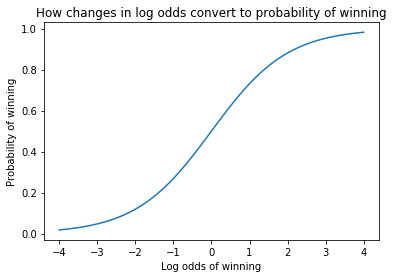

In [6]:
xs = np.linspace(-4,4,100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1/(1+np.exp(-xs)))
pl.show()

# Sumarizando o Impacto de Todas as Features do Conjunto de Dados

Um valor SHAP para uma feature de predição especifica representa a possibilidade de vizualizar o quanto a predição do modelo poe mudar de acordo com a feature obervada. Na representação gráfica abaixo, nós podemos obervar o valor SHAP para uma feature específica (como o ganho de ouro - goldenearned), onde o eixo X representa o valor SHAP (para nosso modelo representa a probabilidade de vitória). Ao fazer isso para todas as features, podemos obervar as features que mais impactam o modelo para predições positivas e negativas (chance de vitória ou derrota). Cada ponto representa o impacto da feature em uma linha de predição do conjunto de dados. As cores indicam o impacto da feature na predição, onde a cor vermelha representa forte impacto e azul o inverso.

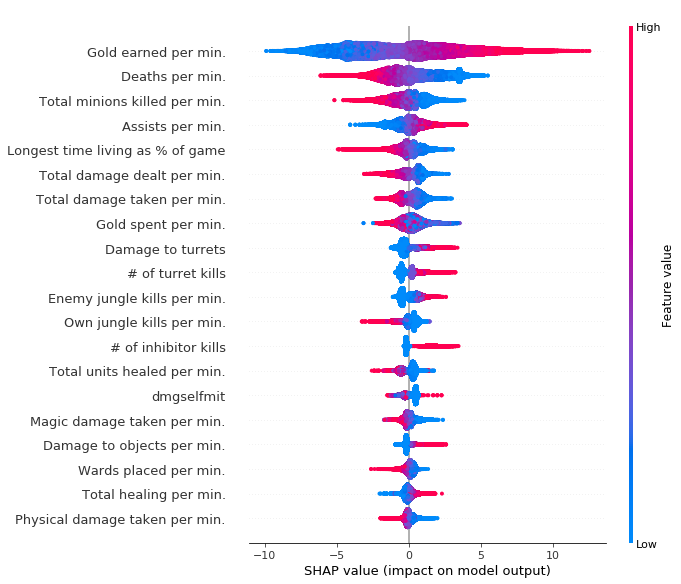

In [7]:
shap.summary_plot(shap_values, Xv)

Ao obervar a representação acima, podemos perceber a feature que mais impacta na probabilidade de vitória (ouro ganho por minuto) e a que mais impacta na probabilidade de derrota (mortes por minuto).

O SHAP é uma ótima ferramenta pra permitir esse tipo de análise, visto que, grandes projetos não podem trabalhar considerando modelos de predição ocultos, onde não se sabe como o modelo está se comportando. Sendo assim, entender como as predições estão acontecendo é de extrema necessidade.